In [1]:
from datascience import *
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Comparing Samples
We spent the previous lectures on comparing samples.

## A/B Testing
We have 2 random samples: sample A and sample B. We want to see if there're any difference between the 2 samples. For example, we analyzed the Deflategate case with Patriots' and Colts' footballs. "Do the 2 teams' footballs looked like they came from the same distribution?"

Often times, whenever we have 2 random samples, we ask, **"Are they drawn from the same underlying distribution?"**.

We can answer this question with **A/B Testing**, which is what we have done so far the past few lectures. It's **A** and **B** because we have sample **A** and **B**. 

## The Hypotheses
Usually our hypotheses for these cases are:

**Null**: The 2 samples are drawn from the same underlying population distribution. They look like 2 random draws from the same set. For example, the Patriots' and Colts' footballs pressure drops were drawn from the same place / distribution. There's not much difference between the 2.

**Alternative**: The 2 samples are drawn from different distributions. They don't look like random draws from the same set.

Our **null** hypothesis are often times contrived since we arbitrarily set a number or a condition to be equal to something. For example, we might assume that our coin is fair, while in reality the coin gives heads 70% of the time. This way, the **null** hypothesis should be that the coin lands on heads 70% of the time. 

In the 2 sample cases, it makes more sense to set the null hypothesis to be "the difference of a statistic is 0" (e.g. the difference in `mean` is 0, or the difference in `median` is 0). 

## Permutation Test
In the previous lectures, we discussed about permutation test. Recall that this is a method that we used for taking new samples from the population given that we have 2 original samples.

**Null**: The 2 samples are drawn randomly from the same underlying distribution

If the **null** is true, then all rearrangements of the data / variable values among the 2 samples are equally likely. In this case:
1. Compute the **observed test statistic**
2. Shuffle the attribute values / data, recompute the statistic, repeat multiple times
3. Compare step 2 with the **observed test statistic**
4. Compute `P-value` as well

## The Test Statistic
Let's have a short aside and discuss about the test statistic.

Often times we deal with 2 broad cases when we compare samples. The cases that we have seen so far were the ones involving **numerical samples**. For example, the drops in football pressures are numerical, and as the test statistic, we took the difference in `mean`.

1. If the samples are numerical, often a simpler statistic is just fine, such as the difference between the distributions in the 2 samples.

Sometimes, the `test statistic` is not as clear (e.g. not a single numerical measure). For example, "do people that workout have bigger T-shirt sizes?". In this case, our sample consists of people who workout and people who don't. We look at their T-shirt sizes distribution: "This person who works out wear S, that person who who doesn't work out wear M, etc.". **This is a categorical data**. Instead of using difference in `mean`, we use TVD. 

2. If the samples are categorical, then a natural test 

All in all, choosing a `test statistic` is the same as what we have done so far:
1. Look at the data
2. Choose a `test statistic` that makes sense based on the data

## Demo
Below we have the same data table as the previous lecture, the newborn babies and whether their mothers smoke.

In [2]:
baby = Table.read_table('baby.csv')
baby.show(3)

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True


Previously, we analyzed the relationship between `Birth Weight` and `Gestational Days`. This time we are going to analyze, 

**Is there any difference in baby weights for mothers who smoke and mothers who don't?**

Our **null** hypothesis in this case is: **there's no relationship between smoking and the babies' weights**

Our **alternate** hypothesis: there is.

For starters, we `group` by `Maternal Smoker` to see how many in the sample are smokers and how many are not.

In [3]:
baby.group('Maternal Smoker')

Maternal Smoker,count
False,715
True,459


Let's see the distribution of babies weight whose mothers are non-smokers.

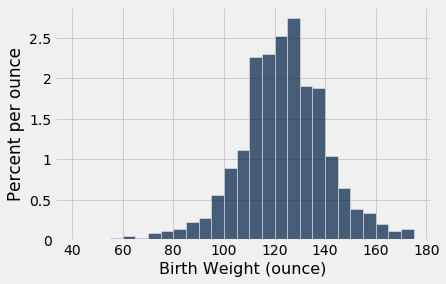

In [4]:
weight_bins = np.arange(40, 180, 5)
baby.where('Maternal Smoker', False).hist('Birth Weight', bins = weight_bins, unit = 'ounce')

It appears that the majority of the babies weights of mothers who don't smoke are around 130-135 ounces. Now let's compare with the distribution of babies weights whose mothers are smokers.

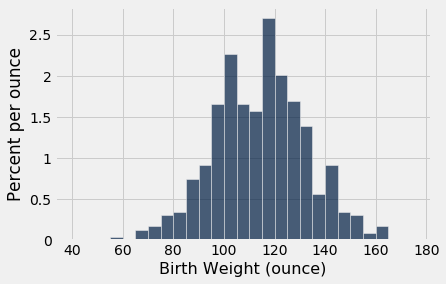

In [5]:
weight_bins = np.arange(40, 180, 5)
baby.where('Maternal Smoker', True).hist('Birth Weight', bins = weight_bins, unit = 'ounce')

The distribution of smokers' babies weights might look a little lower than that of non-smokers. To see the distribution comparison more clearly, we can construct an overlay histogram.

To do this, first we set the same bins as above to both distribution.

In [6]:
noSmokeWeight = baby.where('Maternal Smoker', False).bin('Birth Weight', bins = weight_bins)
noSmokeWeight

bin,Birth Weight count
40,0
45,0
50,0
55,1
60,2
65,1
70,3
75,4
80,5
85,8


In [7]:
smokeWeight = baby.where('Maternal Smoker', True).bin('Birth Weight', bins = weight_bins)
smokeWeight

bin,Birth Weight count
40,0
45,0
50,0
55,1
60,0
65,3
70,4
75,7
80,8
85,17


Then use the `join` method to combine the 2 `bins` above,

In [8]:
joinedbins = noSmokeWeight.join('bin', smokeWeight)
joinedbins

bin,Birth Weight count,Birth Weight count_2
40,0,0
45,0,0
50,0,0
55,1,1
60,2,0
65,1,3
70,3,4
75,4,7
80,5,8
85,8,17


Now we can create a an overlay histogram out of the combined `bin`s above,

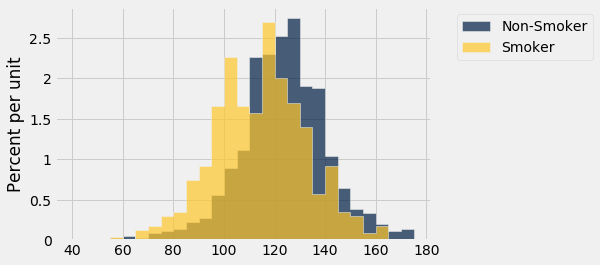

In [9]:
joinedbins.relabel(1, 'Non-Smoker').relabel(2, 'Smoker').hist(bin_column = 'bin')

Looking at both distributions above, will there be a significant difference in `mean` baby weights if we run a hypothesis test?

The distribution above shows a majority overlap between the 2 distributions. However, for every single bin,
1. At the right part of the distribution, there are more babies in **non-smoker** category sticking out
2. At the left part of the distribution, there are more babies in **smoker** category sticking out 

This shows that there might not be any significant difference, but there might be a systematic difference present. Let's see if we can quantify the difference in hypothesis test.

In [10]:
baby.show(3)

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True


As for the `test statistic`, we choose **difference in `mean` weight**.
1. Take the weight of babies whose mothers smoke and those who don't
2. Find the `mean` weight for both
3. Calculate the difference in `mean` weight (take absolute value)
    * Again, we take absolute value because the **alternative** hypothesis is that smoking is associated with baby weights. It doesn't say whether smokers' baby weights are heavier or lighter.
    
The cell below covers step #1 and #2,

In [11]:
smoke_weight = baby.select('Maternal Smoker', 'Birth Weight')
means = smoke_weight.group('Maternal Smoker', np.mean)
means

Maternal Smoker,Birth Weight mean
False,123.085
True,113.819


Now we can calculate the difference in `mean` weight,

In [12]:
means.column(1).item(0) - means.column(1).item(1)

9.266142572024918

We are going to do the steps above multiple times, so it will be convenient to create a function out of the steps above. The function `difference_in_means` takes a table with 2 columns,
1. Column 1 = Maternal Smoker
2. Column 2 = Values we want to analyze

and the function will return the `test statistic`, which is the **difference in `mean` of** whatever value we are analyzing. Note that here we **subtract the baby weight of non-smokers with those of smokers**.

In [13]:
def difference_in_means(t):
    """ Calculates the difference in mean of whatever we are analyzing. """
    means = t.group(0, np.mean)
    return means.column(1).item(0) - means.column(1).item(1)

Now let's test if the function above works correctly,

In [14]:
difference_in_means(smoke_weight)

9.266142572024918

The function works! 

Below we have another function that runs the entire permutation test. The function `permutation_test_means` does the following,
1. Computes the observed test statistic
2. Shuffle the data
3. Recompute the 

In [15]:
def permutation_test_means(table, variable, classes, repetitions, unit = None):
    """ Test whether 2 numerical samples come from the same distribution
    by calculating the absolute difference between the means of
    the 2 samples.
    table : the original table (i.e. baby)
    variable: label of column containing the numerical variable (i.e. Birth Weight)
    classes: label for the 2-category variable in table (i.e. Maternal Smoker)
    repetitions: number of random permutations
    """
    
    # Take only the relevant column from the original table
    t = table.select(classes, variable)
    observed = abs(difference_in_means(t))
    
    # Assuming the null is true, randomly permute / shuffle the variable
    # and collect the generated test statistics
    
    test_stats = make_array() #This array collects the generated test statistics
    for i in np.arange(repetitions):
        # Shuffle the values. The resulting line below is an array
        shuffled_variable = t.select(variable).sample(with_replacement = False).column(0)
        # From the 't' table, grab only the 'classes' column, then
        # add the generated array above as the new 'variable' column
        shuffled_t = t.select(classes).with_column('Shuffled Variables', shuffled_variable)
        # Append the calculated test_statistic to the list "test_stats
        test_stats = np.append(test_stats, abs(difference_in_means(shuffled_t)))
        
    # Calculate the empirical P-value
    p = np.count_nonzero(test_stats >= observed) / repetitions
    
    # Draw the empirical histogram
    Table().with_column('Test Statistic', test_stats).hist(unit = unit)
    plt.title('Empirical Distribution Under the Null')
    print('Observed Statistic:', observed)
    print('Empirical P-value:', p)

Below is how we use the function above,

Observed Statistic: 9.266142572024918
Empirical P-value: 0.0


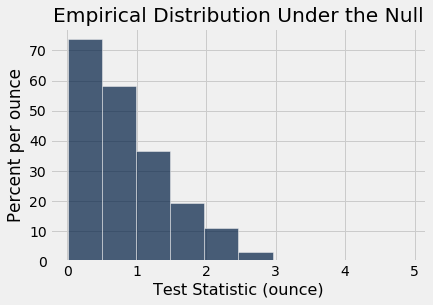

In [16]:
permutation_test_means(baby, 'Birth Weight', 'Maternal Smoker', 1000, 'ounce')

Based on the result above, what can we conclude? 

If the **null** hypothesis is true, that smoking does not affect babies weight, then our observed test statistic should be close to 0. However, as we can see the observed test statistic is 9.266, which is significantly far from our distribution. This is also reflected by the fact that our `P-value` is 0, which says that if the **null** were true, we will never obtain the observed result. 

From this conclusion, we can **reject the null**. However, the most that we can say is that there is an association between smoking and baby weights. We don't know the direction of the association and how big of a difference between the 2. 

Hypothesis tests allow us to answer "is there an association?" or "is something more/less likely to occur?". However, we can't use hypothesis test to obtain **effect size**.

# Effect Size
## How Big is The Difference?
Even though hypothesis test can't answer this question, fortunately there's something else that we can use.

If we think that the 2 underlying population `mean`s might be different, we will want to know how different they are. In this case, instead of running a "same/different" test, **don't make any hypotheses**. Just estimate the difference between the 2 population means.

From the permutation test, we calculated the observed test statistic to be 9.26. Our question this time is, "how big can that vary?"

Instead of conducting a hypothesis test, we can answer this question by bootstrapping the sample and constructing the **confidence interval** for the parameter: **"difference between the population means"**. The confidence interval will give us a range of values that we think is possible. 

## Demo
Recall the previous lecture, we defined the function `bootstrap_ci_mean`. 

In [17]:
def bootstrap_ci_mean(sample_from_population, label, repetitions):
    # Use the `bootstrap_mean` method and store the values in the list "resampled_means"
    resampled_means = bootstrap_mean(sample_from_population, label, repetitions)
    
    # Compute the left 2.5% and right 2.5% cutoffs
    interval_95 = make_array(
        percentile(2.5, resampled_means),
        percentile(97.5, resampled_means)
    )
    
    #Construct the histogram and the 95% Confidence Interval horizontal line
    Table().with_column('Resampled mean', resampled_means).hist('Resampled mean')
    plt.plot(interval_95, [0, 0], color = 'gold', lw = 8)
    print('Approximate 95% Bootstrap Confidence Interval for the Population Mean:')
    print(np.round(interval_95, 3))

However, the function above uses the function `bootstrap_mean` instead of `difference_in_means`. 

In [18]:
def bootstrap_mean(sample_from_population, label, repetitions):
    """ Returns a list of resampled mean.
    sample_from_population: An original sample taken from the population
    label: the label within the sample table that we want to bootstrap
    repetitions: the number of repetition
    
    """
    resampled_mean = []
    for i in np.arange(repetitions):
        resample = sample_from_population.sample()
        # Below we use np.mean
        resampled_mean.append(np.mean(resample.column(label)))
    return resampled_mean

In this case, we will re-write the `bootstrap_ci_mean` function so that it uses `difference_in_means`. Note that we still use 95% confidence interval.

In [19]:
def bootstrap_ci_mean(table, variable, classes, repetitions, unit = None):
    # Take only the relevant columns from the original table on a separate table
    t = table.select(classes, variable)
    
    test_stats = make_array()
    for i in np.arange(repetitions):
        # Resample the original sample
        resample = t.sample()
        test_stats = np.append(test_stats, difference_in_means(resample))
        
    # Calculate the left 2.5% and right 2.5% cutoffs
    left = percentile(2.5, test_stats)
    right = percentile(97.5, test_stats)
    
    # Construct the histogram and the 95% confidence interval line
    Table().with_column('Difference Between Means', test_stats).hist(unit = unit)
    plt.plot([left, right], [0, 0], color = 'yellow', lw = 8)
    print('Approximate 95% CI for the difference between means:')
    print(left, 'to', right)

Now we can use the function above to construct the 95% confidence interval of the **difference in mean weight**.

Approximate 95% CI for the difference between means:
7.236123069246986 to 11.390551916271377


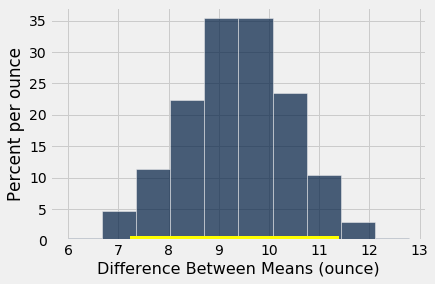

In [20]:
bootstrap_ci_mean(baby, 'Birth Weight', 'Maternal Smoker', 1000, 'ounce')

Notice that the **difference** above is NOT **absolute difference**. Instead, it's the **non-smokers minus smokers**. It appeares that the babies of smokers are 7 to 11 ounces lower than those of non-smokers. 

From the method above, we obtain 2 things:
1. Which group weight less
2. How big the difference is

Now that we have analyzed the `difference in mean` of baby weights, we can analyze other variables too.

In [21]:
baby.show(3)

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True


### Smoking and Maternal Age
Now let's try and see if there's any association between smoking and maternal age. Since we have the function `permutation_test_means` ready, we can just use this function.

Observed Statistic: 0.8076725017901509
Empirical P-value: 0.017


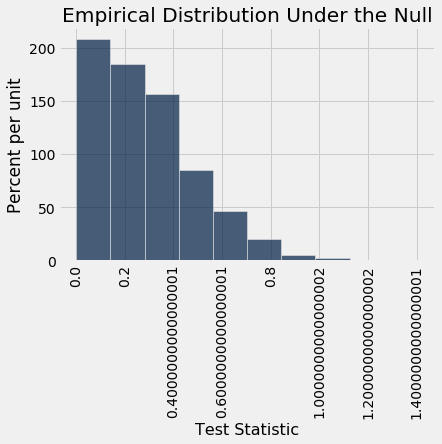

In [22]:
permutation_test_means(baby, 'Maternal Age', 'Maternal Smoker', 1000)

With a `P-value` of 0.02 or 2%, seems like there is an association between smoking and maternal age! Now let's see the 95% confidence interval of **difference in mean maternal age**.

Approximate 95% CI for the difference between means:
0.10626210379231793 to 1.4305064403437733


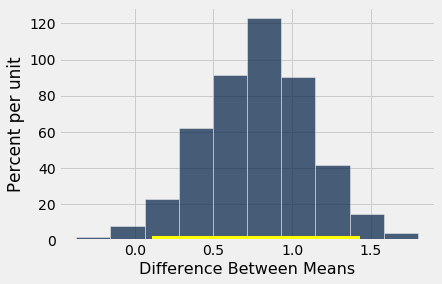

In [23]:
bootstrap_ci_mean(baby, 'Maternal Age', 'Maternal Smoker', 1000)

And from above, we can conclude that the age of non-smokers are, in average, about 0.1 to 1.4 years older than that of smokers. 

### Smoking and Maternal Height
Now what about maternal height? Is there any association between the mothers' heights and whether they smoke?

Observed Statistic: 0.09058914941267915
Empirical P-value: 0.552


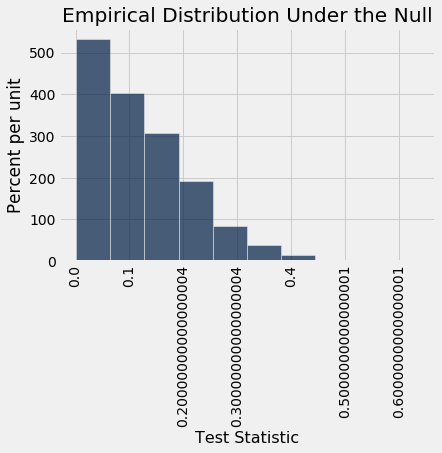

In [24]:
permutation_test_means(baby, 'Maternal Height', 'Maternal Smoker', 1000)

Our `P-value` is around 0.55, which is relatively high! This way, we can't conclude that there's any association between smoking and maternal height. If we still try to construct the 95% confidence interval,

Approximate 95% CI for the difference between means:
-0.39856574767829045 to 0.21432422257360884


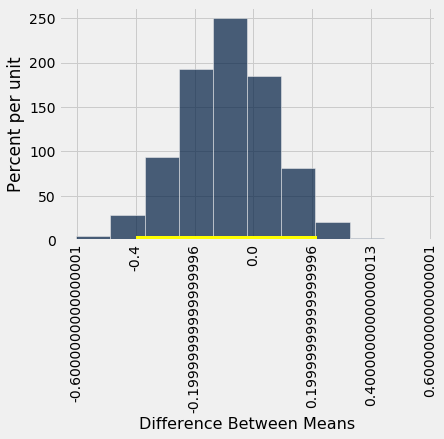

In [25]:
bootstrap_ci_mean(baby, 'Maternal Height', 'Maternal Smoker', 1000)

Notice that 0 is contained within the 95% confidence interval above, and thus it is totally possible to find no difference between the height of smokers and non-smokers at all. 

Even if from hypothesis test we found that there is no difference between the 2 groups, we can still compute the confidence interval and obtain difference just by chance. 

A good exercise to get used to this is to predict beforehand whether there is a relationship or not. In the real world, we have a lot more variables (e.g. hundreds of columns compared to 6 columns in `baby` table). 

# Randomized Controlled Experiments
Now we are going back to the second lecture of the course, where we discussed about John Snow. John Snow suspected that the water caused cholera. Thus, he surveyed the people to see if people drank from the pump and how many people died, and from there he suggested to remove the Broad Street pump handle. 

From what he did, John managed to established association. He was able to say that "the deaths happened to be clustered around the pump" and "when the pump handle was removed, people happened to stop being sick from cholera". However, he wasn't able to establish a causation that "water caused cholera". 

From there, he had to do more work, which is analyzing the map of the 2 water companies and look at the area where the 2 companies' services overlap. He made an important assumption that people who lived in that area pick one of the 2 companies by random. With this assumption, he can say that the group receiving water from S&V and the group receiving water from Lambeth look the same. This **random assignment** gets rid of possibility of difference if, for example, only rich people got water from Lambeth. 

## Causality
The key of establishing causality is,

If we have **Sample A as the control group** and **Sample B as the treatment group**, they need to be similar in every aspect except the treatment. Only then we can say that the treatment must have caused the effect.

In addition, we can make causal conclusions **if the treatment and control groups are selected at random**.

For example, if we have a group of tall people and a group of short people, they need to be randomly shuffled into the control and treatment groups. The randomness allow us to say that the 2 groups look mostly the same.

If the requirements above are fulfilled, any difference in outcomes between the 2 groups could be due to
1. Chance
2. The treatment

This is now a standard for many fields such as medicine. If people in such field want to establish causality (e.g. the medicine makes people feel better), they need to run a randomized controlled experiments.

## Demo
Here we have an example of medicine-related data. The data came from an experiment of whether the botulinum toxin helps with chronic back pain. Patients's spine were injected with the botulinum toxin and were observed to see if there were any improvement. 

In [26]:
bta = Table.read_table('bta.csv')
bta

Group,Result
Control,1
Control,1
Control,0
Control,0
Control,0
Control,0
Control,0
Control,0
Control,0
Control,0


The column `Group` categorizes each patient to either control or treatment group, while the `Result` column categorizes whether the patient felt better `(1)` or not at all `(0)`.

This was a **randomized control trial**. The participants were separated into 2 groups, but they were not informed regarding who got what treatment. The control group received salines solution, while the treatment group received the saline solution. The test administrator (the person who gave the treatment) did not know which was which either. This is called a **double-blind experiment**, where neither the patients nor the people giving treatment know who is receiving what treatment.

Let's see if we can find any difference between the 2 groups, and from there we can see whether we can establish causality. 

We can start with taking the average of the result for each group,

In [27]:
bta.group('Group', np.mean)

Group,Result mean
Control,0.125
Treatment,0.6


Above, 60% of the people who received treatment felt better, compared to 12.5% of people who just received saline solution. We can check whether there are actually any difference using the `permutation_test_means` function,

Observed Statistic: 0.475
Empirical P-value: 0.009


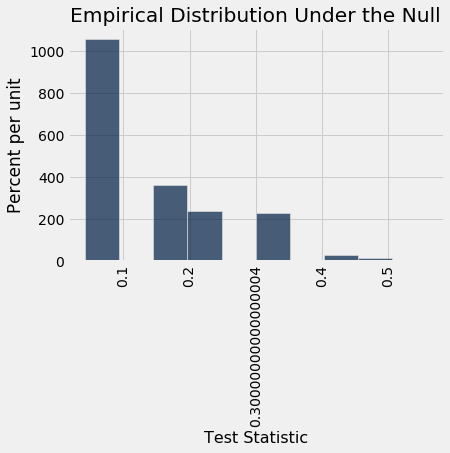

In [28]:
permutation_test_means(bta, 'Result', 'Group', 1000)

We see an observed mean difference of `0.475` (which can be calculated by subtracting `0.6` with `0.125`). With a relatively low `P-value` (less than 5%), we can conclude that there is indeed a difference between the control group and the treatment group. If we do the 95% confidence interval to the data,

Approximate 95% CI for the difference between means:
-0.7571428571428571 to -0.15714285714285714


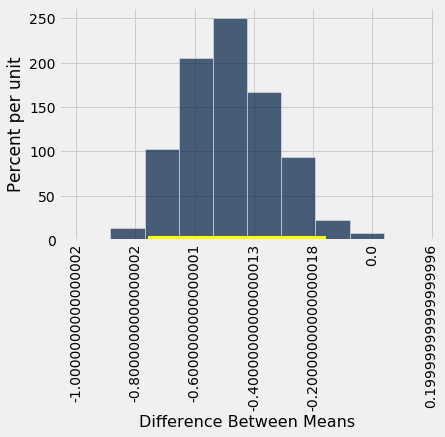

In [29]:
bootstrap_ci_mean(bta, 'Result', 'Group', 1000)

Above, we have 95% confidence interval for difference between means. However, what is the significance of that? 

If we recall the original table,

In [30]:
bta.show(3)

Group,Result
Control,1
Control,1
Control,0


We indicate `1` for someone who ended up feeling better and `0` for someone who did not feel any better during the experiment. If we take the `mean` of the result, we obtain the **proportion of people who felt better**. 

Now back to the result of 95% confidence interval, the difference between `mean` is actually the **difference between proportion**.

Imagine every body in the world (the population) has a back pain. If we give some people saline solution (or placebo) only, while we give some others the treatment, the % of people who received saline solution and felt better is 12.5%, while the % of people who received the treatment and felt better is 60%. The parameter in this case is **the difference in proportion**. The confidence interval is estimating that the actual proportion difference is between 75% to 15%. 

It appears that indeed, people felt better after the treament. We don't have an accurate estimate of a difference since 15-75% is a relatively large range; however, we can say that there is a difference since the difference is not 0.

If we want the interval to be smaller, we need to have larger sample size. The more people we have in the dataset, the less variation we have in the sample statistic and thus, we can obtain a more precise interval.

Since this dataset came from a RCT (Randomized Controlled Trial), we can conclude that the treatment caused people to felt better. The data suggested that the treatment indeed has a causal effect to the back pain. 